In [148]:
# Se der erro é so importar de novo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import scikitplot as skplt
from imblearn.combine import SMOTETomek

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

In [149]:
xgb.__version__

'0.90'

In [150]:
df = pd.read_excel('dados-0905.xlsx')

In [151]:
# Considerar os municípios com menos casos como OUTROS

df.loc[(df['NM_MUNICIP'] != 'VITORIA')
       & (df['NM_MUNICIP'] != 'VILA VELHA')
       & (df['NM_MUNICIP'] != 'SERRA')
       & (df['NM_MUNICIP'] != 'CARIACICA'), 'NM_MUNICIP'] = 'OUTROS'

In [152]:
# Diferença de dias entre a notificação e o 1o sintoma

df['DIF_DIAS'] = (df['DT_NOTIFIC'] - df['DT_SIN_PRI']).astype(str).apply(lambda x: x[:2])
df['DIF_DIAS'] = df['DIF_DIAS'].astype('int32')

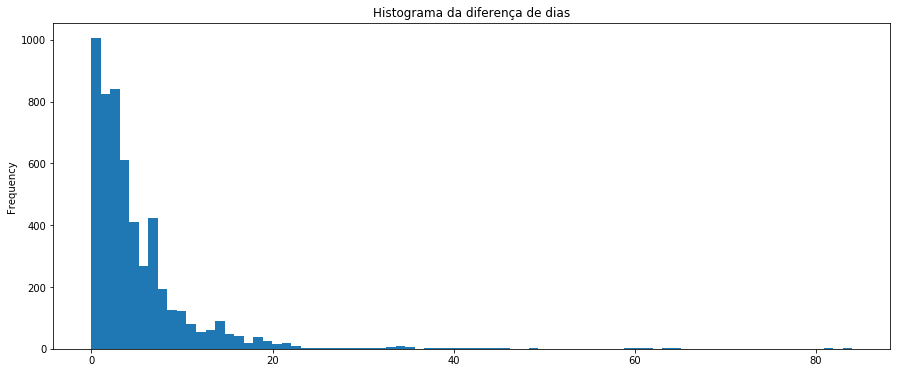

In [153]:
plt.figure(figsize = (15,6))
df['DIF_DIAS'].plot(kind='hist',bins=80)
plt.title('Histograma da diferença de dias')
plt.show()

In [154]:
features = [#'NM_MUNICIP',
 'DIF_DIAS',
 'NU_IDADE_N',
 'CS_SEXO',
 'CS_GESTANT',
 #'NM_BAIRRO',
 #'NM_NAO_ENCONTRADO',
 #'CS_ZONA',
 'IS_PROFISSIONAL_SAUDE',
 'SINT_FEBRE',
 'SINT_DIF_RESP',
 'SINT_NARIZ',
 'SINT_TIRAG',
 'SINT_CIAN',
 'SINT_SAT',
 'SINT_COMA',
 'SINT_TOSSE',
 'SINT_ESCA',
 'SINT_CONG_NAZ',
 'SINT_CORIZA',
 'SINT_GARGANTA',
 'SINT_DIARREIA',
 'SINT_NAUZ',
 'SINT_CEFALEIA',
 'SINT_IRRITABI',
 'SINT_ADINAMIA',
 'SINT_EXSUDATO',
 'SINT_CONJUT',
 'SINT_CONVULSAO',
 'SINT_DIF_ENGO',
 'CONTATO_SUSP',
 'VIAGEM_BRASIL',
 'VIAGEM_INTERNACIONAL',
 'COMORB_PULM',
 'COMORB_CARDIO',
 'COMORB_RENAL',
 'COMORB_HEPAT',
 'COMORB_DIABE',
 'COMORB_IMUN',
 'COMORB_HIV',
 'COMORB_NEOPL',
 'COMORB_TABAG',
 'COMORB_CIRURGIA_BARIAT',
 'COMORB_OBESIDADE',
 'COMORB_TUBERCULOSE',
 'COMORB_NEOPLASIAS',
 'COMORB_NEURO_CRONICA',
 'NM_SINTOMAS_OUTROS',
 'CLASS_FINAL',]

In [155]:
df = df[features]

In [156]:
# observei que alguns casos possuem 9 em todos os sintomas

df = df[df['SINT_FEBRE'] != 9]

In [157]:
df = df[df['NU_IDADE_N'] > 18]

## Outros sintomas

Dispneia e Mialgia tem uma presença relevante na feature 'NM_SINTOMAS_OUTROS', portanto foram criadas features para esses 2 sintomas

In [158]:
# retirando acentuações e transformando em lowercase

import unidecode
import unicodedata

df['NM_SINTOMAS_OUTROS'].fillna('Nenhum', inplace = True)
df['NM_SINTOMAS_OUTROS'] = df['NM_SINTOMAS_OUTROS'].apply(unidecode.unidecode)
df['NM_SINTOMAS_OUTROS'] = df['NM_SINTOMAS_OUTROS'].apply(lambda x: x.lower())

In [159]:
df['SINT_DISPNEIA'] = 0
df.loc[df['NM_SINTOMAS_OUTROS'].str.contains('dispneia', na = False), 'SINT_DISPNEIA'] = 1

In [160]:
df['SINT_MIALGIA'] = 0
df.loc[df['NM_SINTOMAS_OUTROS'].str.contains('mialgia', na = False), 'SINT_MIALGIA'] = 1

In [161]:
df.drop('NM_SINTOMAS_OUTROS',1,inplace=True)

### CLASS_FINAL

In [162]:
df['CLASS_FINAL'].value_counts()

1.0    1985
4.0    1821
3.0     808
Name: CLASS_FINAL, dtype: int64

In [163]:
df.loc[df['CLASS_FINAL'] == 2, 'CLASS_FINAL'] = 3
df['CLASS_FINAL'].fillna(1, inplace = True)
df = df.loc[df['CLASS_FINAL'] != 1]

In [164]:
df.loc[df['CLASS_FINAL'] == 3, 'CLASS_FINAL'] = 1
df.loc[df['CLASS_FINAL'] == 4, 'CLASS_FINAL'] = 0

In [165]:
df.reset_index(drop = True, inplace=True)

## Transformando as features binárias

Os valores 9, 1 e NaN serão considerados 0, e os valores 2 serão considerados 1

In [166]:
features_cat = ['IS_PROFISSIONAL_SAUDE',
 'SINT_FEBRE',
 'SINT_DIF_RESP',
 'SINT_NARIZ',
 'SINT_TIRAG',
 'SINT_CIAN',
 'SINT_SAT',
 'SINT_COMA',
 'SINT_TOSSE',
 'SINT_ESCA',
 'SINT_CONG_NAZ',
 'SINT_CORIZA',
 'SINT_GARGANTA',
 'SINT_DIARREIA',
 'SINT_NAUZ',
 'SINT_CEFALEIA',
 'SINT_IRRITABI',
 'SINT_ADINAMIA',
 'SINT_EXSUDATO',
 'SINT_CONJUT',
 'SINT_CONVULSAO',
 'SINT_DIF_ENGO',
 'CONTATO_SUSP',
 'VIAGEM_BRASIL',
 'VIAGEM_INTERNACIONAL',
 'COMORB_PULM',
 'COMORB_CARDIO',
 'COMORB_RENAL',
 'COMORB_HEPAT',
 'COMORB_DIABE',
 'COMORB_IMUN',
 'COMORB_HIV',
 'COMORB_NEOPL',
 'COMORB_TABAG',
 'COMORB_CIRURGIA_BARIAT',
 'COMORB_OBESIDADE',
 'COMORB_TUBERCULOSE',
 'COMORB_NEOPLASIAS',
 'COMORB_NEURO_CRONICA']

In [167]:
for feature in features_cat:
    df.loc[df[feature] == 2, feature] = 0
    df.loc[df[feature] == 9, feature] = np.nan

In [168]:
df['SINT_GARGANTA'] = df['SINT_GARGANTA'] + df['SINT_DIF_ENGO']
df.loc[df['SINT_GARGANTA'] >= 1, 'SINT_GARGANTA'] = 1

df['SINT_DISPNEIA'] = df['SINT_DISPNEIA'] + df['SINT_DIF_RESP']
df.loc[df['SINT_DISPNEIA'] >= 1, 'SINT_DISPNEIA'] = 1

df.drop(['SINT_DIF_ENGO','SINT_DIF_RESP'],1,inplace=True)

### CS_GESTANT

In [169]:
gestante = ['3º trimeste', '2º trimeste','1º trimeste']
df.loc[df['CS_GESTANT'].isin(gestante), 'CS_GESTANT'] = 1
df.loc[df['CS_GESTANT'] != 1, 'CS_GESTANT'] = 0

## Sexo

In [170]:
df.loc[df['CS_SEXO'] == 'Ignorado', 'CS_SEXO'] = 'Masculino'

In [171]:
df.to_csv('describe.csv')

## Dummies

In [172]:
df = pd.get_dummies(df, drop_first=True)

# knn imputer

In [173]:
from sklearn.impute import KNNImputer
num_feat = df.dtypes[df.dtypes.values != 'O'].index
imputer = KNNImputer(n_neighbors=10)

df[num_feat] = imputer.fit_transform(df[num_feat])

## Missing Values 

In [174]:
df.isnull().sum()

DIF_DIAS                  0
NU_IDADE_N                0
IS_PROFISSIONAL_SAUDE     0
SINT_FEBRE                0
SINT_NARIZ                0
SINT_TIRAG                0
SINT_CIAN                 0
SINT_SAT                  0
SINT_COMA                 0
SINT_TOSSE                0
SINT_ESCA                 0
SINT_CONG_NAZ             0
SINT_CORIZA               0
SINT_GARGANTA             0
SINT_DIARREIA             0
SINT_NAUZ                 0
SINT_CEFALEIA             0
SINT_IRRITABI             0
SINT_ADINAMIA             0
SINT_EXSUDATO             0
SINT_CONJUT               0
SINT_CONVULSAO            0
CONTATO_SUSP              0
VIAGEM_BRASIL             0
VIAGEM_INTERNACIONAL      0
COMORB_PULM               0
COMORB_CARDIO             0
COMORB_RENAL              0
COMORB_HEPAT              0
COMORB_DIABE              0
COMORB_IMUN               0
COMORB_HIV                0
COMORB_NEOPL              0
COMORB_TABAG              0
COMORB_CIRURGIA_BARIAT    0
COMORB_OBESIDADE    

## Train test split e balanceamento

In [175]:
colunas = df.drop('CLASS_FINAL',1).columns

In [176]:
X = df.drop('CLASS_FINAL',1)
y = df['CLASS_FINAL']

Xres, X_test, yres, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

sampling_strategy = 0.9
ru = SMOTETomek(sampling_strategy=sampling_strategy)
Xres, yres = ru.fit_sample(Xres, yres)

## Scaler

In [177]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 

scaler = MinMaxScaler()
scaler.fit(Xres)
Xres = pd.DataFrame(scaler.transform(Xres), columns = colunas)
X_test = pd.DataFrame(scaler.transform(X_test), columns = colunas)

In [178]:
pickle.dump(scaler, open("scaler.dat", "wb"))

In [179]:
Xres.shape

(2705, 43)

In [180]:
yres.shape

(2705,)

In [181]:
# Função para avaliar as métricas

def report(y,pred, prob):
    print(classification_report(y, pred))
    print(confusion_matrix(y, pred))
    print("ROC_AUC_SCORE: ",roc_auc_score(y, prob))

# Função para alterar o threshold to modelo

def thold(th, prob):
    thold = th
    predicted = (prob [:,1] >= thold).astype('int')
    prob = prob[:,1]
    return report(y_test, predicted, prob)

def thold_pred(th, prob):
    thold = th
    return (prob [:,1] >= thold).astype('int')

## SVM

In [182]:
svc = SVC(probability=True)
svc.fit(Xres,yres)
svc_prob = svc.predict_proba(X_test)

In [183]:
thold(0.15,svc_prob)

              precision    recall  f1-score   support

         0.0       0.88      0.19      0.31       356
         1.0       0.36      0.95      0.52       170

    accuracy                           0.44       526
   macro avg       0.62      0.57      0.42       526
weighted avg       0.71      0.44      0.38       526

[[ 68 288]
 [  9 161]]
ROC_AUC_SCORE:  0.6890779907468606


In [184]:
svc_prob.shape

(526, 2)

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


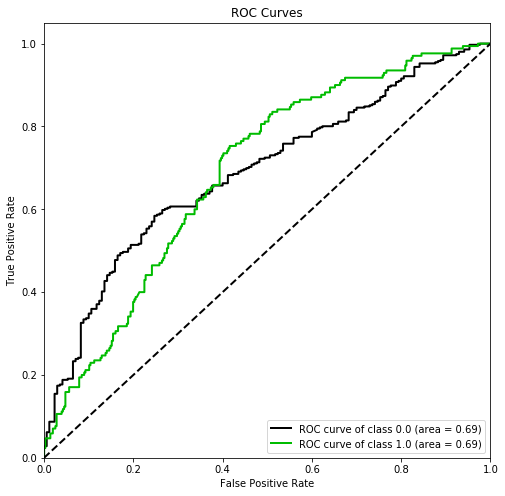

In [185]:
skplt.metrics.plot_roc_curve(y_test, svc_prob, figsize=(8,8), curves='each_class')
plt.show()

## Logistic Regression

In [186]:
lr = LogisticRegression()

lr.fit(Xres,yres)
lr_prob = lr.predict_proba(X_test)

In [187]:
thold(0.25,lr_prob)

              precision    recall  f1-score   support

         0.0       0.87      0.16      0.27       356
         1.0       0.35      0.95      0.51       170

    accuracy                           0.42       526
   macro avg       0.61      0.55      0.39       526
weighted avg       0.70      0.42      0.35       526

[[ 58 298]
 [  9 161]]
ROC_AUC_SCORE:  0.6683906146728354


Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


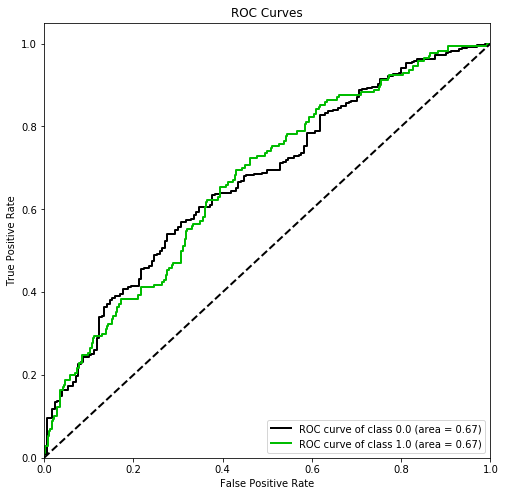

In [188]:
skplt.metrics.plot_roc_curve(y_test, lr_prob, figsize=(8,8), curves='each_class')
plt.show()

## MLP

In [189]:
mlp =  MLPClassifier()

mlp.fit(Xres,yres)
mlp_prob = mlp.predict_proba(X_test)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [190]:
thold(0.05,mlp_prob)

              precision    recall  f1-score   support

         0.0       0.87      0.19      0.31       356
         1.0       0.36      0.94      0.52       170

    accuracy                           0.43       526
   macro avg       0.61      0.56      0.41       526
weighted avg       0.70      0.43      0.38       526

[[ 67 289]
 [ 10 160]]
ROC_AUC_SCORE:  0.6717944481163252


Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


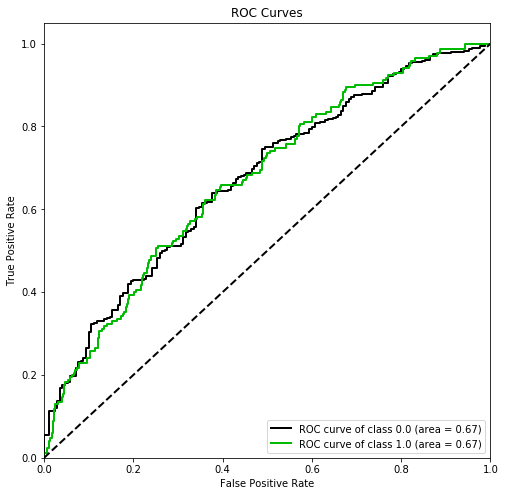

In [191]:
skplt.metrics.plot_roc_curve(y_test, mlp_prob, figsize=(8,8), curves='each_class')
plt.show()

## Gradient Boosting

In [192]:
gbc = GradientBoostingClassifier()

gbc.fit(Xres,yres)
gbc_prob = gbc.predict_proba(X_test)

In [193]:
thold(0.2,gbc_prob)

              precision    recall  f1-score   support

         0.0       0.90      0.39      0.54       356
         1.0       0.42      0.91      0.57       170

    accuracy                           0.56       526
   macro avg       0.66      0.65      0.56       526
weighted avg       0.74      0.56      0.55       526

[[139 217]
 [ 16 154]]
ROC_AUC_SCORE:  0.7403998678122933


Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


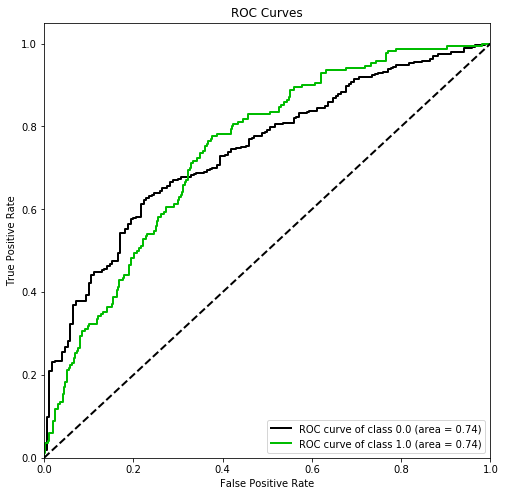

In [194]:
skplt.metrics.plot_roc_curve(y_test, gbc_prob, figsize=(8,8), curves='each_class')
plt.show()

## Extra Trees

In [195]:
from sklearn.ensemble import ExtraTreesClassifier

ext = ExtraTreesClassifier(n_estimators=100, max_depth=80)
ext.fit(Xres,yres)
ext_prob = ext.predict_proba(X_test)          

In [196]:
thold(0.15,ext_prob)

              precision    recall  f1-score   support

         0.0       0.90      0.39      0.54       356
         1.0       0.41      0.91      0.57       170

    accuracy                           0.56       526
   macro avg       0.66      0.65      0.55       526
weighted avg       0.74      0.56      0.55       526

[[138 218]
 [ 16 154]]
ROC_AUC_SCORE:  0.7243886318572372


Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


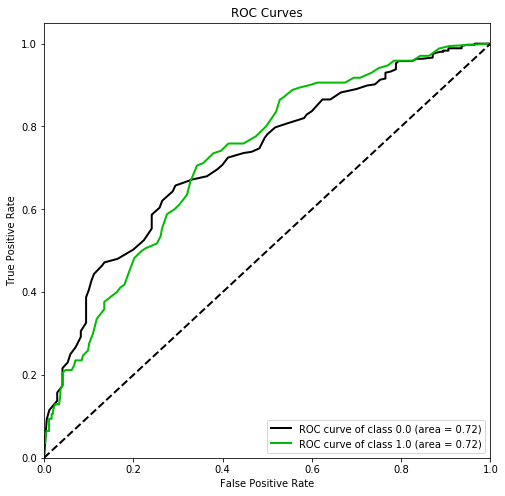

In [197]:
skplt.metrics.plot_roc_curve(y_test, ext_prob, figsize=(8,8), curves='each_class')
plt.show()

## Random Forest

In [198]:
rf = RandomForestClassifier(n_estimators = 75,max_depth=80)
rf.fit(Xres,yres)
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)

In [199]:
thold(0.2,rf_prob)

              precision    recall  f1-score   support

         0.0       0.88      0.39      0.54       356
         1.0       0.41      0.89      0.56       170

    accuracy                           0.55       526
   macro avg       0.65      0.64      0.55       526
weighted avg       0.73      0.55      0.55       526

[[138 218]
 [ 18 152]]
ROC_AUC_SCORE:  0.7321877065432914


Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


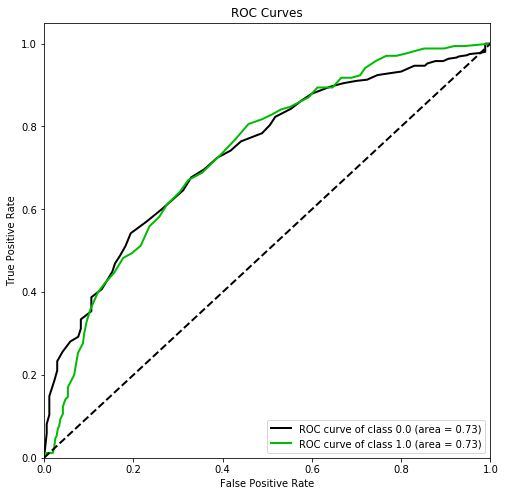

In [200]:
skplt.metrics.plot_roc_curve(y_test, rf_prob, figsize=(8,8), curves='each_class')
plt.show()

## XGB

In [201]:
clf = xgb.XGBClassifier(n_estimators = 300)

clf.fit(Xres, yres)
clf_prob = clf.predict_proba(X_test)

In [202]:
thold(0.15,clf_prob)

              precision    recall  f1-score   support

         0.0       0.92      0.43      0.59       356
         1.0       0.44      0.92      0.59       170

    accuracy                           0.59       526
   macro avg       0.68      0.68      0.59       526
weighted avg       0.76      0.59      0.59       526

[[153 203]
 [ 13 157]]
ROC_AUC_SCORE:  0.7558327825512227


Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


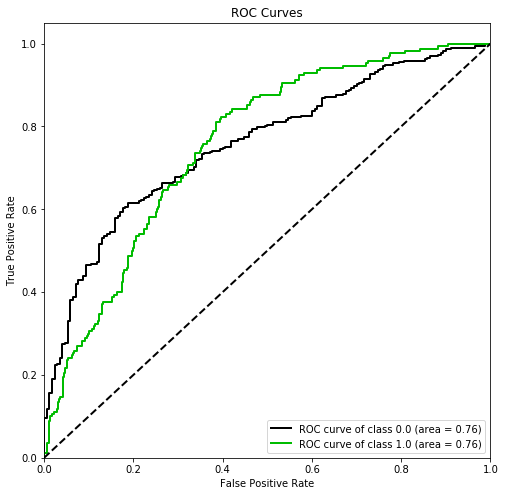

In [203]:
skplt.metrics.plot_roc_curve(y_test, clf_prob, figsize=(8,8), curves='each_class')
plt.show()

In [204]:
pickle.dump(clf, open("clf.dat", "wb"))

## Feature Importances

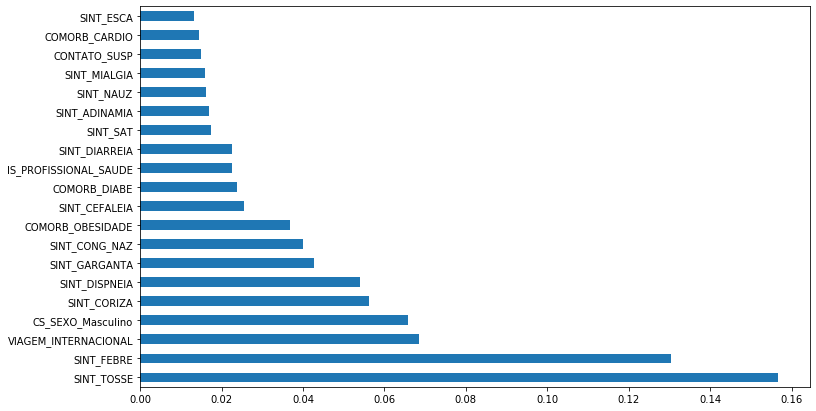

In [205]:
plt.figure(figsize=(12,7))
feat_importances = pd.Series(clf.feature_importances_, index= X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [206]:
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
    'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

In [207]:
from sklearn.base import clone
def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [208]:
drop_col_feat_imp(clf, Xres, yres, random_state = 42)

,feature,feature_importance
0,NU_IDADE_N,0.011091
1,IS_PROFISSIONAL_SAUDE,0.007763
2,DIF_DIAS,0.004806
3,SINT_ADINAMIA,0.003327
4,SINT_ESCA,0.002957
5,SINT_GARGANTA,0.002588
6,SINT_DISPNEIA,0.002218
7,COMORB_PULM,0.002218
8,CS_SEXO_Masculino,0.001848
9,VIAGEM_INTERNACIONAL,0.001848


In [209]:
import shap

Xres_names=pd.DataFrame(data=Xres,columns=X.columns)

shap.initjs()

#model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(Xres_names, label=yres), 100)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(Xres_names)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], Xres_names.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


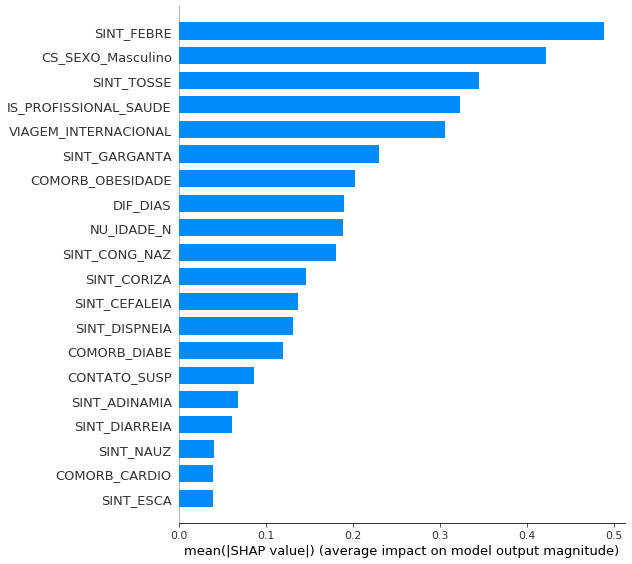

In [210]:
shap.summary_plot(shap_values, X, plot_type="bar")

### XGBOOST

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Explainer expected value: [-0.10797778]


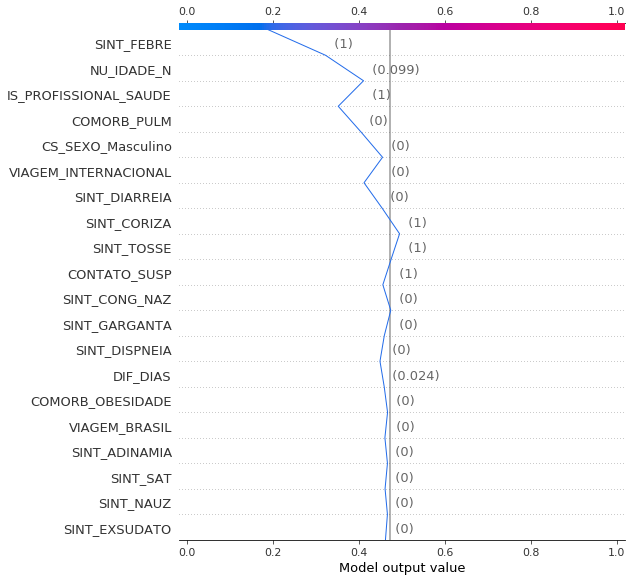

In [224]:
import warnings
explainer = shap.TreeExplainer(clf)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value, shap_values, features_display, link ='logit')

### Random Forest

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Explainer expected value: [0.52684165 0.47315835]


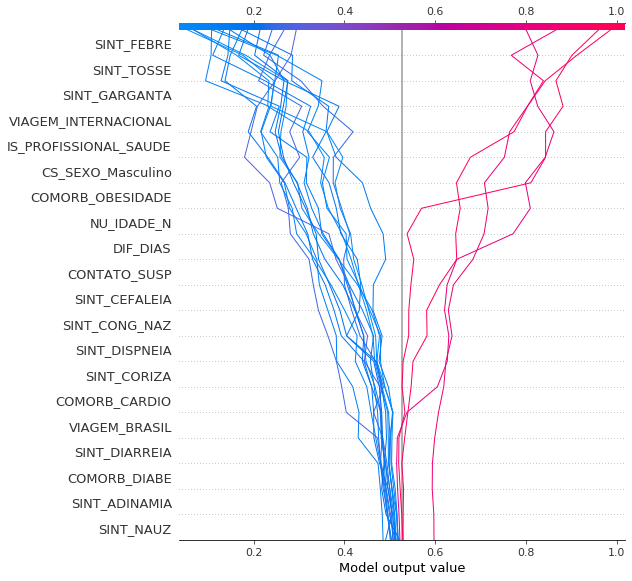

In [212]:
import warnings
explainer = shap.TreeExplainer(rf)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value[0], shap_values, features_display)

## Odds Ratio

In [213]:
import statsmodels.api as sm
import statsmodels

In [214]:
df_odds_ratio = Xres.copy()
yres = yres.apply(int)
df_odds_ratio['CLASS_FINAL'] = yres
df_odds_ratio = statsmodels.tools.tools.add_constant(df_odds_ratio, prepend=True, has_constant='add')

In [215]:
model = sm.Logit(df_odds_ratio['CLASS_FINAL'], df_odds_ratio.drop(['CLASS_FINAL','COMORB_OBESIDADE','COMORB_TUBERCULOSE',
                                                                   'COMORB_NEOPLASIAS','COMORB_CIRURGIA_BARIAT'],1))

In [216]:
res = model.fit()

Optimization terminated successfully.
         Current function value: 0.622444
         Iterations 6


In [217]:
print (res.summary())

                           Logit Regression Results                           
Dep. Variable:            CLASS_FINAL   No. Observations:                 2705
Model:                          Logit   Df Residuals:                     2665
Method:                           MLE   Df Model:                           39
Date:                Sun, 21 Jun 2020   Pseudo R-squ.:                  0.1001
Time:                        18:47:16   Log-Likelihood:                -1683.7
converged:                       True   LL-Null:                       -1871.0
Covariance Type:            nonrobust   LLR p-value:                 2.079e-56
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.9459      0.178     -5.317      0.000      -1.295      -0.597
DIF_DIAS                 -0.2314      0.600     -0.386      0.700      -1.407       0.944
NU_IDADE

In [218]:
params = np.exp(res.params)
conf = np.exp(res.conf_int()) 
conf['OR'] = params
pvalue = round(res.pvalues, 3)
conf['Valor-p'] = pvalue 
#Imprime os resultados
conf.columns = ['IC 95%(2.5%)', 'IC 95%(97.5%)', 'Odds Ratio', 'Valor-p']
print((conf))

                       IC 95%(2.5%)  IC 95%(97.5%)  Odds Ratio  Valor-p
const                      0.274019       0.550332    0.388331    0.000
DIF_DIAS                   0.244839       2.571226    0.793433    0.700
NU_IDADE_N                 0.448935       1.306606    0.765886    0.328
IS_PROFISSIONAL_SAUDE      1.137418       1.797055    1.429686    0.002
SINT_FEBRE                 1.770804       2.565498    2.131430    0.000
SINT_NARIZ                 0.117809       2.554431    0.548574    0.444
SINT_TIRAG                 0.287429       3.572904    1.013389    0.983
SINT_CIAN                  0.680177      11.662271    2.816452    0.153
SINT_SAT                   0.552348       1.364965    0.868295    0.541
SINT_COMA                  0.224652       4.480245    1.003242    0.997
SINT_TOSSE                 1.697910       2.545046    2.078764    0.000
SINT_ESCA                  0.535001       1.075992    0.758721    0.121
SINT_CONG_NAZ              1.266389       2.137751    1.645365  